1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to graphically display the regions.
* Use `scipy.optimize.minimize()`, trying its optional arguments.

In [12]:
import numpy as np
import pandas as pd
from scipy import fftpack
from matplotlib.colors import LogNorm
from scipy.optimize import basinhopping
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import optimize

%matplotlib inline

Finding the global minima of the given function:

Text(0, 0.5, 'y')

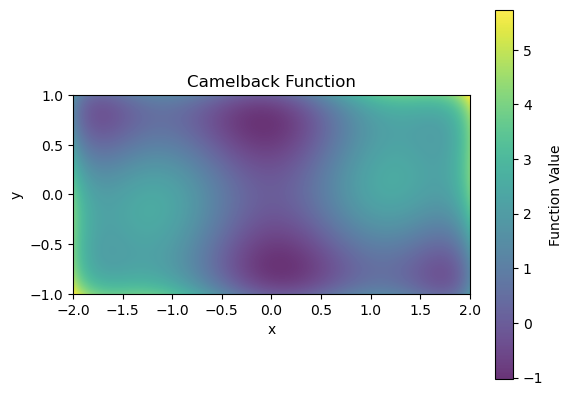

In [13]:
# Defining the function described in the text
def f(x):
    return (4 - 2.1 * x[0]**2 + x[0]**4/3) * x[0]**2 + x[0]*x[1] + (4 * x[1]**2 - 4) * x[1]**2

# Generating values for x and y
x_val = np.linspace(-2, 2, 400)
y_val = np.linspace(-1, 1, 200)
xv, yv = np.meshgrid(x_val, y_val)
sol = f([xv,yv]) # sending the meshgrid datapoints through the function

# Plotting the result, which is a six-hump camelback function
plt.imshow(sol, extent=[-2, 2, -1, 1], origin='lower', cmap='viridis', alpha=0.8)
plt.colorbar(label='Function Value')
plt.title('Camelback Function')
plt.xlabel('x')
plt.ylabel('y')


In [14]:
# Finding the global minimum of function, using scipy.optimize.minimize
init0 = [0, 0.5] # Initial guess

# Defining constraints described in the text
con = ({'type': 'ineq', 'fun': lambda x: 2 - x[0]}, {'type': 'ineq', 'fun': lambda x: x[0] + 2},
        {'type': 'ineq', 'fun': lambda x: 1 - x[1]}, {'type': 'ineq', 'fun': lambda x: x[1] + 1})

# Computing the result for the global minima
result0 = optimize.minimize(f, init0, constraints = con)
print(result0)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0316284523624513
       x: [-8.984e-02  7.126e-01]
     nit: 6
     jac: [ 1.605e-05 -1.878e-04]
    nfev: 20
    njev: 6


In [15]:
# Finding the global minimum of function, using basinhopping
init = [0, 0.5] # initial guess

result = basinhopping(f, init, niter=200, stepsize = 0.5) # Choosing number of iterations = 200 and stepsize = 0.5
print("Global minimum: (x,y) = (%.4f, %.4f), f(x,y) = %.4f" % (result.x[0], result.x[1], result.fun))

Global minimum: (x,y) = (-0.0898, 0.7127), f(x,y) = -1.0316


Using both spipy.optimize.minimize and basinhopping yields the same result; that the global minima is found in $x = -0.0898$ and $y = 0.7127$ with a function value of $f(x,y) = -1.0316$. 

Now determining how many global minima there are:

In [5]:
# Determining the number of global minima and function values
init2 = [0, -0.5]
con = ({'type': 'ineq', 'fun': lambda x: 2 - x[0]}, {'type': 'ineq', 'fun': lambda x: x[0] + 2},
        {'type': 'ineq', 'fun': lambda x: 1 - x[1]}, {'type': 'ineq', 'fun': lambda x: x[1] + 1})

result2 = optimize.minimize(f, init2, constraints = con)
print(result2)
print()

init3 = [-2, 1]
con = ({'type': 'ineq', 'fun': lambda x: 2 - x[0]}, {'type': 'ineq', 'fun': lambda x: x[0] + 2},
        {'type': 'ineq', 'fun': lambda x: 1 - x[1]}, {'type': 'ineq', 'fun': lambda x: x[1] + 1})

result3 = optimize.minimize(f, init3, constraints = con)
print(result3)
print()

init4 = [2, -1]
con = ({'type': 'ineq', 'fun': lambda x: 2 - x[0]}, {'type': 'ineq', 'fun': lambda x: x[0] + 2},
        {'type': 'ineq', 'fun': lambda x: 1 - x[1]}, {'type': 'ineq', 'fun': lambda x: x[1] + 1})

result4 = optimize.minimize(f, init4, constraints = con)
print(result4)
print()
print("In total we see 2 global minima.")
print("The function value for (x,y) = (-0.0898, 0.7127) and (x,y) = (0.0898, -0.7127) is f(x,y) = -1.0316 for both minima")

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0316284523650276
       x: [ 8.984e-02 -7.126e-01]
     nit: 6
     jac: [-1.605e-05  1.878e-04]
    nfev: 20
    njev: 6

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.21546365068364626
       x: [-1.703e+00  7.961e-01]
     nit: 7
     jac: [ 2.534e-03  6.281e-04]
    nfev: 27
    njev: 7

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.21546365066401263
       x: [ 1.703e+00 -7.961e-01]
     nit: 7
     jac: [-2.534e-03 -6.281e-04]
    nfev: 27
    njev: 7

In total we see 2 global minima.
The function value for (x,y) = (-0.0898, 0.7127) and (x,y) = (0.0898, -0.7127) is f(x,y) = -1.0316 for both minima


This means that the global minima is mirrored in the y-axis, which is also visible from the plot above. $\newline$
Now investigating what happens if the initial guess is $(x,y) = (0,0)$:

In [16]:
# Initial guess (0,0)
init5 = [0,0]
result5 = optimize.minimize(f, init5, constraints = con)
print(result5)
print()
print("When the initial guess is (x,y) = (0,0) the algorithm returns the point (0,0) as a global minima with \nfunction value f(0,0) = 0")

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0
       x: [ 0.000e+00  0.000e+00]
     nit: 1
     jac: [ 5.960e-08 -5.960e-08]
    nfev: 3
    njev: 1

When the initial guess is (x,y) = (0,0) the algorithm returns the point (0,0) as a global minima with 
function value f(0,0) = 0


2\. **Non-linear ODE: the damped pendulum**

The equation of the motion of a forced pendulum, as a function of the angle $\theta$ with the vertical, is given by:

$$\frac{d^2\theta}{dt^2} = -\frac{1}{Q} \frac{d\theta}{dt} + \frac{g}{l}\sin\theta + d \cos\Omega t$$

where $t$ is time, $Q$ is the damping factor, $d$ is the forcing amplitude, and $\Omega$ is the driving frequency of the forcing. 

This second order ODE needs to be written as two coupled first order ODEs by defining a new variable $\omega \equiv d\theta/dt$:

$$\frac{d\theta}{dt} = \omega$$
$$\frac{d\omega}{dt} = -\frac{1}{Q}\,\omega + \frac{g}{l}\sin\theta + d \cos\Omega t$$

Consider the initial conditions $\theta_0 = \omega_0 = 0$, and $l = 10$, $Q = 2.0$, $d = 1.5$, and $\omega = 0.65$.

 - Solve the ODE with `odeint` over a period of 200 time steps
 - Create two plots, one of $\theta$ as a function of the time, and $\omega$ as a function of the time
 - **Optional**: determine if there is a set of parameters for which the motion is chaotic.

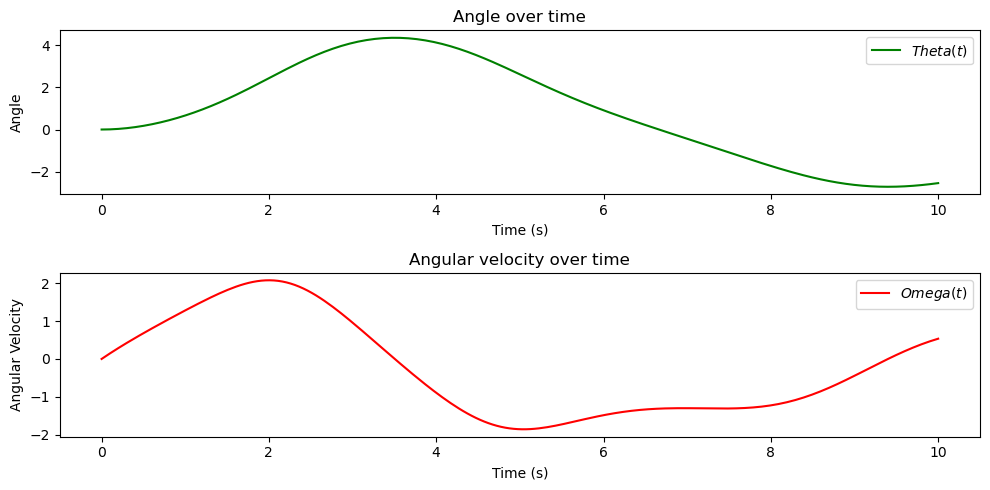

In [17]:
# Defining the given constants
l = 10
Q = 2.0
d = 1.5
Omega = 0.65

# Defining the derivative function as given in the text
def derivative(X, time, l, Q, d, Omega):
    return(X[1], -1/Q * X[1] + 9.807/l*np.sin(X[0]) + d * np.cos(Omega * time))

# Generating 200 timesteps
t = np.linspace(0, 10, 200)
Xinit = (0, 0) # Initial guess
solution = odeint(derivative, Xinit, t, args=(l, Q, d, Omega)) #Computing the result

# Plot theta as a function of time
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(t, solution[:, 0], label=r'$Theta(t)$', color = 'green')
plt.title('Angle over time')
plt.xlabel('Time (s)')
plt.ylabel('Angle')
plt.legend()

# Plot omega as a function of time
plt.subplot(2, 1, 2)
plt.plot(t, solution[:, 1], label=r'$Omega(t)$', color='red')
plt.title('Angular velocity over time')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity')
plt.legend()

plt.tight_layout()
plt.show()

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

The dataset is the one downloaded at the beginning of Lecture 06:

 - `!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/`

In [210]:
!wget https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt -P data/

--2023-12-17 17:33:46--  https://www.dropbox.com/s/ebe1cnyd2gm836a/populations.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ebe1cnyd2gm836a/populations.txt [following]
--2023-12-17 17:33:47--  https://www.dropbox.com/s/raw/ebe1cnyd2gm836a/populations.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce4c5d326e38d279268b831b04c.dl.dropboxusercontent.com/cd/0/inline/CJkn5n1_dz024FdzPlxr7ZTfJQO6R0T7qMzZuvn3jQzy6N_2bmhR8zXKS61XvmxXICJAH6rJkaHU1kmmvXqaBSUZUbVZRjQwyJKYrfg-OG9tjaZQhC273U2QN5H3cGhS97M/file# [following]
--2023-12-17 17:33:47--  https://uce4c5d326e38d279268b831b04c.dl.dropboxusercontent.com/cd/0/inline/CJkn5n1_dz024FdzPlxr7ZTfJQO6R0T7qMzZuvn3jQzy6N_2bmhR8zXKS61XvmxXICJAH6rJkaHU1kmmvXqaBSUZUbVZRjQwyJKYrfg-OG9tjaZQhC273U2QN5H3cGhS97M/file
Res

In [18]:
# Importing the dataset as a csv file
df0 = pd.read_csv('./data/populations.txt', sep = "\t")
df0

,# year,hare,lynx,carrot
0,1900,30000.0,4000.0,48300
1,1901,47200.0,6100.0,48200
2,1902,70200.0,9800.0,41500
3,1903,77400.0,35200.0,38200
4,1904,36300.0,59400.0,40600
5,1905,20600.0,41700.0,39800
6,1906,18100.0,19000.0,38600
7,1907,21400.0,13000.0,42300
8,1908,22000.0,8300.0,44500
9,1909,25400.0,9100.0,42100


In [19]:
# Creating two arrays from the columns "year" and "lynx"
year = df0['# year'].to_numpy()
lynx = df0['lynx'].to_numpy()

# Performing the fast Fourier transformation on the "lynx" array
lynx_fft = fftpack.fft(lynx)
lynx_fft_freq = fftpack.fftfreq(len(lynx), d=1)

# Considering only the real part of the signal (positive frequencies)
i = lynx_fft_freq > 0

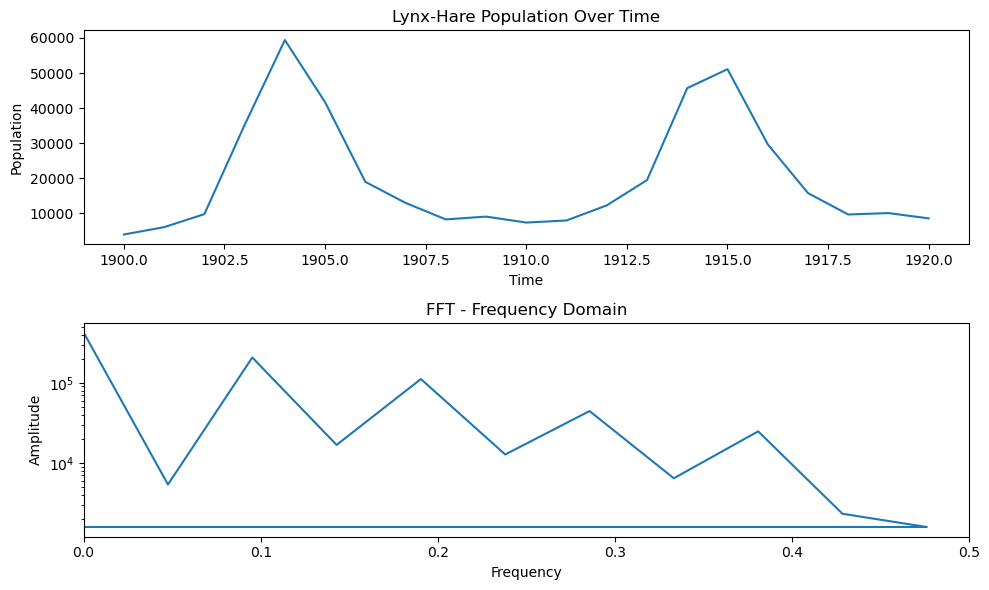

In [20]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(year, lynx)
plt.title('Lynx-Hare Population Over Time')
plt.xlabel('Time')
plt.ylabel('Population')

plt.subplot(2, 1, 2)
plt.plot(lynx_fft_freq, np.abs(lynx_fft))
plt.title('FFT - Frequency Domain')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(0, 0.5)  # Show only positive frequencies

plt.tight_layout()
plt.show()

We see from the plots that the period of the population for these animals is approximately 10 years, which can be induced from the length of the peaks shown in the first plot. 

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("images/moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the 2D regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

<function matplotlib.pyplot.show(close=None, block=None)>

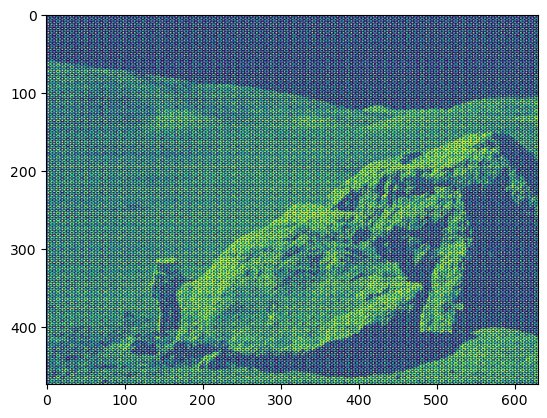

In [27]:
# Reading the image
img = plt.imread("images/moonlanding.png")

# Showing the image
plt.imshow(img)
plt.show

We see the picture above is very grainy and heavily contaminated. Below is performed the 2D fast Fourier transformation, which can clean the image.

<function matplotlib.pyplot.show(close=None, block=None)>

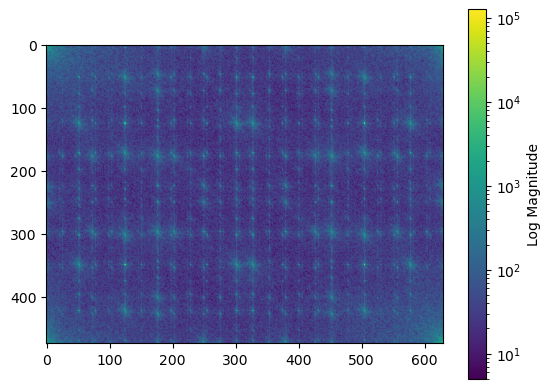

In [24]:
# Computing the power spectrum showing where the contamination is the heaviest
img_fft = fftpack.fft2(img)

# Plotting the power spectrum
plt.imshow(np.abs(img_fft), norm = LogNorm(vmin = 5))
plt.colorbar(label='Log Magnitude')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

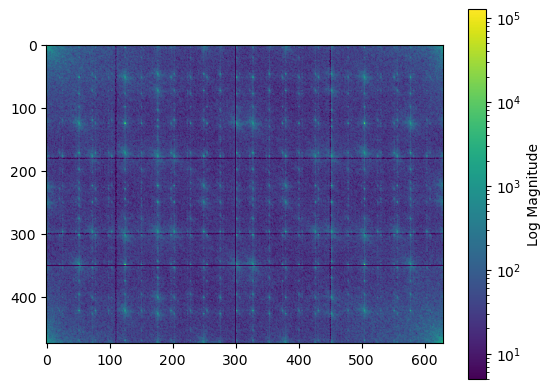

In [25]:
# Using the power spectrum as reference, several slicings are performed to set the noise regions to zero. 
noise_threshold_x1 = 180
img_fft[noise_threshold_x1:noise_threshold_x1 + 2, :] = 0

noise_threshold_y2 = 450
img_fft[:, noise_threshold_y2:noise_threshold_y2 + 2] = 0

noise_threshold_y3 = 110
img_fft[:, noise_threshold_y3:noise_threshold_y3 + 2] = 0

noise_threshold_x3 = 350
img_fft[noise_threshold_x3:noise_threshold_x3 + 2, :] = 0

noise_threshold_x2 = 300
img_fft[noise_threshold_x2:noise_threshold_x2 + 2, :] = 0

noise_threshold_y4 = 300
img_fft[:, noise_threshold_y4:noise_threshold_y4 + 2] = 0

# Now plotting the power spectrum with the slicings 
plt.imshow(np.abs(img_fft), norm = LogNorm(vmin = 5))
plt.colorbar(label='Log Magnitude')
plt.show

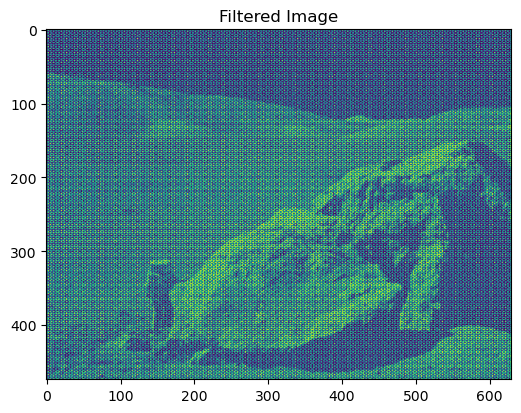

In [26]:
# Now computing the image with the noise regions set to zero
filtered_image = np.abs(fftpack.ifft2(img_fft))

# Plotting the filtered image
plt.figure(figsize=(6, 6))
plt.title('Filtered Image')
plt.imshow(filtered_image)
plt.show()

In the image above we see an improvement from the first image. It is difficult to slice out all the noise regions, so the result is more a demonstration of the concept. 